# Introduction

We intend to predict the next 21 days of sales for each item sold by Fair Storage across their shops in Singapore. After performed EDA and having fitted statistical models like Arima and ETS(AAA) (which you can review in the Statistical Forecasting submission), we move onto Machine Learning models. We report here on our best performing ML model, and LGBM model. The other approaches tried included XGBOOST model and Random Forest models.

## Disclaimer:

In this notebook, we restrict our data to the last 150 observations for each time series. This is done for compilation and demonstration purposes. Compiling the notebook with the entirety of the data available would have been unfeasible with the time constraint given for the project. 

In [ ]:
# !pip install plotly
# !pip install lightgbm

In [3]:
import time
import plotly.express as px
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
import lightgbm as lgb
import random 
import datetime
import warnings
warnings.filterwarnings("ignore")

To start us off, we read the data from the csv-s.  

In [2]:
def read_data ():
    df = pd.read_csv("train.csv", index_col = 0)
    calendar = pd.read_csv("calendar.csv", index_col = None)
    prices = pd.read_csv("prices.csv")
    return df, calendar, prices

In order to reduce the amount of storage used by the data frames, we do some downcasting. This way we achieve the downsizing by about one fourth and thus reduce the chances of getting memory allocation errors. 

In [3]:
# Source: #https://www.kaggle.com/anshuls235/time-series-forecasting-eda-fe-modelling/notebook#2.-Downcasting

def downcast(df):

    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()

    for i,t in enumerate(types):

        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)

        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)

        elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')

    return df

We now read the data.

Again, we extract the last 150 days for compilation and demonstration purposes. Please, skip this step if you wish to replicate the results obtained on the Kaggle competition.

In [59]:
sales, calendar, prices = read_data () 

In [60]:
#take the last 150 days
month_sales = sales.iloc[:, 1769: ]
month_sales['id'] = month_sales.index
month_sales.head()

,d_1765,d_1766,d_1767,d_1768,d_1769,d_1770,d_1771,d_1772,d_1773,d_1774,...,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,id
id,,,,,,,,,,,,,,,,,,,,,
Beauty_1_001_East_1,1,2,2,0,1,0,0,0,0,1,...,0,1,1,0,0,0,2,0,3,Beauty_1_001_East_1
Beauty_1_002_East_1,0,1,0,0,0,0,0,2,1,0,...,0,0,0,0,1,0,0,0,0,Beauty_1_002_East_1
Beauty_1_003_East_1,2,3,0,1,1,0,0,0,0,2,...,1,1,1,0,0,1,1,0,2,Beauty_1_003_East_1
Beauty_1_004_East_1,2,4,3,0,5,1,3,3,2,0,...,3,7,2,0,0,1,2,4,1,Beauty_1_004_East_1
Beauty_1_005_East_1,0,0,2,1,0,0,1,2,0,1,...,2,2,4,1,0,2,3,1,0,Beauty_1_005_East_1


In [61]:
month_calendar = calendar.iloc[1764:, :]
month_calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d
1764,2015-11-28,11544,Saturday,1,11,2015,d_1765
1765,2015-11-29,11544,Sunday,2,11,2015,d_1766
1766,2015-11-30,11544,Monday,3,11,2015,d_1767
1767,2015-12-01,11544,Tuesday,4,12,2015,d_1768
1768,2015-12-02,11544,Wednesday,5,12,2015,d_1769


In [62]:
sales = downcast(month_sales)
cal = downcast(month_calendar)
price = downcast(prices) 

# Cleaning and Merging

We are now ready to proceed with preparing the data for modelling. Our first step is to create the columns for the days we will be predicting. 

In [63]:
for day in range(1920,1941):
    sales['d_' + str(day)] = 0
    sales['d_' + str(day)] = sales['d_' + str(day)].astype(np.int16)

For our convenience, we convert the data set to long format (panel format), allowing us to more easily perform operations on columns, get feature importance, etc. thanks to greater accessibility. 

In [64]:
df_melt = pd.melt(sales, id_vars = [a for a in sales.columns if a.find("id") != -1],
                           value_vars = [a for a in sales.columns if a.find("d_") == 0], var_name = 'd', value_name = 'sales')
df_melt.head()

,id,d,sales
0,Beauty_1_001_East_1,d_1765,1
1,Beauty_1_002_East_1,d_1765,0
2,Beauty_1_003_East_1,d_1765,2
3,Beauty_1_004_East_1,d_1765,2
4,Beauty_1_005_East_1,d_1765,0


Then, we merge the three data sets:

In [65]:
df_melt = pd.merge(df_melt, cal, on = 'd', how = 'left')

#restore the store and item columns in df_melt
df_melt["store_id"] = df_melt['id'].copy().apply(lambda x: "_".join(x.split('_')[3:]))
df_melt["item_id"] = df_melt['id'].copy().apply(lambda x: "_".join(x.split('_')[0:3]))
df_melt["region_id"] = df_melt['id'].copy().apply(lambda x: (x.split('_')[3]))
#Use the columns to retrieve corresponding price
df_melt = pd.merge(df_melt, price, on = ['store_id',
'item_id','wm_yr_wk'], how = 'left')

And fill in any of the null values in the sell price column with id means. 

In [66]:
df_melt["sell_price"].fillna(df_melt.groupby("id")["sell_price"].transform("mean"), inplace=True)

Since the information on data and weekday is contained in other columns in the data set, we can safely drop them from our analysis. 

In [67]:
df_melt.drop(columns=["date","weekday"], inplace=True)
df_melt['d'] = df_melt['d'].apply(lambda a: a.split('_')[1]).astype(np.int16)

To further prepare the data set for modelling, we label encode the categorical features. 

In [68]:
columns = list(df_melt.columns)
d_types = list(df_melt.dtypes.values)

for a, d_t in enumerate(d_types):
    if d_t.name == 'category' or d_t.name == 'object':
        df_melt[columns[a]]= df_melt[columns[a]].astype('category')
        df_melt[columns[a]] = df_melt[columns[a]].cat.codes

We also introduce several lags, which will help with forecasting, since we can now use previous values as a feature. Our lags start at 21, because using smaller lags will give poor test results since some of the prediction columns will be at 0. The lags scored high on feature importance in other models previously fitted, allowing us to include this lags confidently.

In [70]:
lags = [21, 28, 35, 42, 49, 56, 63, 70, 77]
for lag in tqdm(lags):
    df_melt["lag_" + str(lag)] = df_melt.groupby("id")["sales"].shift(lag).astype(np.float16)

100%|██████████| 9/9 [00:02<00:00,  3.18it/s]


We also introduce some rolling median features. 

In [71]:
df_melt['lag_21'] = df_melt.groupby('id')['sales'].transform(lambda x: x.shift(21))

df_melt['rolling_median_7'] = df_melt.groupby('id')['lag_21'].transform(lambda x: x.rolling(7).median())
df_melt['rolling_median_21'] = df_melt.groupby('id')['lag_21'].transform(lambda x: x.rolling(21).median())
df_melt['rolling_median_50'] = df_melt.groupby('id')['lag_21'].transform(lambda x: x.rolling(50).median())

We proceed to subset the dataframe, as the first 77 columns's lag data are incomplete. This is bound to happen when including lags, and we will lose some training data for every lag introduced as feature. However, due to the high importance of these lags in other models (RandomForest, XGBOOST) that have been fitted before this one, we are confident this trade off will be positive.

In [72]:
df_melt = df_melt[df_melt['d'] > 1842]
df_melt.tail()

,id,d,sales,wm_yr_wk,wday,month,year,store_id,item_id,region_id,...,lag_35,lag_42,lag_49,lag_56,lag_63,lag_70,lag_77,rolling_median_7,rolling_median_21,rolling_median_50
5366235,30449,1940,0,11617,1,5,2016,9,3044,2,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
5366236,30459,1940,0,11617,1,5,2016,9,3045,2,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5366237,30469,1940,0,11617,1,5,2016,9,3046,2,...,1.0,2.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0
5366238,30479,1940,0,11617,1,5,2016,9,3047,2,...,0.0,1.0,0.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0
5366239,30489,1940,0,11617,1,5,2016,9,3048,2,...,0.0,1.0,3.0,0.0,1.0,2.0,3.0,0.0,0.0,0.5


Checking our dataset for null values, we are assured that there are none. 

In [73]:
assert(df_melt.isnull().any().sum() == 0)

Finally, we split the data into the training, validation, and the testing set. 

In [144]:
def train_test_split (df_melt, test_start, val_start):
    X_train = df_melt[df_melt["d"] < val_start].drop("sales", axis=1)
    X_val =  df_melt[(df_melt['d'] >= val_start) & (df_melt['d']< test_start)].drop('sales',axis=1)
    X_test = df_melt[df_melt["d"] >= test_start].drop("sales", axis=1)

    y_train = df_melt[df_melt["d"] < val_start]["sales"]
    y_val = df_melt[(df_melt['d'] >= val_start) & (df_melt['d']< test_start)]["sales"]

    return X_train, X_val,X_test,y_train,y_val
X_train, X_val,X_test,y_train,y_val = train_test_split (df_melt, 1920, 1899)

To get the equivalent item id in the calendar dataset, we join the item and store IDs. We also get rid of the d in front of the day number to turn it into an integer. 

In [75]:
cols = ["item_id", "store_id"]
price['id'] = price[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
cal["d"] = cal["d"].apply(lambda a: int(a.split("_")[1]))

# Hyperparameter tuning, modelling and validation

We infer the forecast, ground truth values, and weights by aggregating:

In [126]:
for day in tqdm(range(1878, 1899)):  
    wk_id = list(cal[cal["d"]==day]["wm_yr_wk"])[0]
    wk_price = price[price["wm_yr_wk"]==wk_id]
    df_sales = sales.merge(wk_price[["sell_price", "id"]], on=["id"], how='inner')
    df_sales["unit_sales_" + str(day)] = df_sales["sell_price"] * df_sales["d_" + str(day)]
    df_sales.drop(columns=["sell_price"], inplace=True)

100%|██████████| 21/21 [00:05<00:00,  3.84it/s]


In [127]:
col = [a for a in df_sales.columns if a.find("unit_sales")==0]
df_sales["sales"] = df_sales[col]
df_sales["weight"] = df_sales["sales"] / df_sales["sales"].sum()
df_sales.drop(columns = ["sales", col[0]], axis=1, inplace=True)
df_sales["weight"] /= 12

In [78]:
aggregation_level = {2: ["region_id"], 3: ["store_id"], 4: ["category_id"], 5: ["subcat_id"], 
              6: ["region_id", "category_id"], 7: ["region_id", "subcat_id"], 8: ["store_id", "category_id"], 9: ["store_id", "subcat_id"],
              10: ["item_id"], 11: ["item_id", "region_id"]}

In order to assess the performance of the model, we define the function to calculate RMSEE:

In [79]:
h = 21
n = 1898

def RMSSE(ground_truth, forecast, train_series):
    
    num = ((ground_truth - forecast)**2).sum(axis=1)
    den = 1/(n-1) * ((train_series[:, 1:] - train_series[:, :-1]) ** 2).sum(axis=1)
    rmsse = (1/h * num/den) ** 0.5

    return rmsse

In order to find the best parameters, we implement a function to compute custom hyperparametrer tuning:

In [86]:
def hyperparameter_tuning(X_train, y_train, model):

    model.fit(X_train, y_train)

    for d in range(1899, 1920):
        df_sales['d_' + str(d)] = model.predict(X_val[X_val['d']==d])
    
    data = df_sales[[a for a in df_sales.columns if a.find("d_") == 0]]
    data = data.sum()

    aggregated_df = pd.DataFrame(data).transpose()    
    aggregated_df["level"] = 1
    aggregated_df["weight"] = 1/12    
    columns = aggregated_df.columns  

    for lev in aggregation_level:
        df_t = df_sales.groupby(by=aggregation_level[lev]).sum().reset_index()
        df_t["level"] = lev
        aggregated_df = aggregated_df.append(df_t[columns])     

    train_columns = [a for a in df_sales.columns if a.find("d_") == 0 and int(a.split('_')[1]) < 1899]
    actual_value_columns = [a for a in df_sales.columns if a.find("d_") == 0 and int(a.split('_')[1]) in range(1899, 1920)]
    forecast_value_columns = [a for a in df_sales.columns if a.find("d_") == 0 and int(a.split('_')[1]) >= 1920]    

    ground_truth_df = np.array(df_sales[actual_value_columns])
    forecast_df = np.array(df_sales[forecast_value_columns])
    train_series_df = np.array(df_sales[train_columns])

    ground_truth_agg_df = np.array(aggregated_df[actual_value_columns])
    forecast_agg_df = np.array(aggregated_df[forecast_value_columns])
    train_series_agg_df = np.array(aggregated_df[train_columns])

    df_sales["rmsse"] = RMSSE(ground_truth_df, forecast_df, train_series_df)
    aggregated_df["rmsse"] = RMSSE(ground_truth_agg_df, forecast_agg_df, train_series_agg_df)

    df_sales["wrmsse"] = df_sales["weight"] * df_sales["rmsse"]
    aggregated_df["wrmsse"] = aggregated_df["weight"] * aggregated_df["rmsse"]

    print(df_sales["wrmsse"].sum() + aggregated_df["wrmsse"].sum())
    
    return (df_sales["wrmsse"].sum() + aggregated_df["wrmsse"].sum())

In [128]:
#restore the store and item columns in df_sales
df_sales["store_id"] = df_sales['id'].copy().apply(lambda x: "_".join(x.split('_')[3:]))
df_sales["item_id"] = df_sales['id'].copy().apply(lambda x: "_".join(x.split('_')[0:3]))
df_sales["region_id"] = df_sales['id'].copy().apply(lambda x: (x.split('_')[3]))
df_sales["category_id"] = df_sales['id'].copy().apply(lambda x: (x.split('_')[0]))
df_sales["subcat_id"] = df_sales['id'].copy().apply(lambda x: (x.split('_')[3]))

columns = list(df_sales.columns)
d_types = list(df_sales.dtypes.values)

for a, d_t in enumerate(d_types):
    if d_t.name == 'category' or d_t.name == 'object':
        df_sales[columns[a]]= df_sales[columns[a]].astype('category')
        df_sales[columns[a]] = df_sales[columns[a]].cat.codes


In [87]:
%%time

wrmsse=[]
lr=[]
n_leaves=[]
min_d_leaf=[]

for _ in tqdm(range(15)):

    learning_rate = random.randint(25, 75)/1000
    num_leaves = random.randint(32, 128)
    min_data_in_leaf = random.randint(50, 150)

    print(learning_rate)
    print(num_leaves)
    print(min_data_in_leaf)
    
    model = lgb.LGBMRegressor(learning_rate= learning_rate,num_leaves=num_leaves,min_data_in_leaf=min_data_in_leaf)
    
    WRMSSE = hyperparameter_tuning(X_train, y_train, model)

    wrmsse.append(WRMSSE)
    lr.append(learning_rate)
    n_leaves.append(num_leaves)
    min_d_leaf.append(min_data_in_leaf)

  0%|          | 0/15 [00:00<?, ?it/s]0.025
94
98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
  7%|▋         | 1/15 [00:07<01:46,  7.59s/it]15.742734622025166
0.031
114
129
[LightGBM] [Warning] min_data_in_leaf is set=129, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=129
 13%|█▎        | 2/15 [00:15<01:41,  7.82s/it]15.850205350100484
0.067
71
132
[LightGBM] [Warning] min_data_in_leaf is set=132, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=132
 20%|██        | 3/15 [00:22<01:28,  7.40s/it]16.161899658280333
0.025
54
100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
 27%|██▋       | 4/15 [00:28<01:16,  6.95s/it]15.722714483772679
0.057
97
97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
 33%|███▎      | 5/15 

Record the hyperparameters

In [88]:
minpos = wrmsse.index(min(wrmsse))
learning_rate = lr[minpos]
num_leaves = n_leaves[minpos]
min_data_in_leaf = min_d_leaf[minpos]

Finally, we are in the position to fit the model on the best parameters. 

In [158]:
m_lgb = lgb.LGBMRegressor( learning_rate=learning_rate ,
                           num_leaves=num_leaves ,
                           min_data_in_leaf=min_data_in_leaf)


In order to assess the quality of the model, we predict the validation data and use Walk-Forward Cross Validation with three splits.

# Walk-forward Validataion

In [155]:
def evaluate_model (df_melt, df_sales, model):
    """ 
    Split the data into 21 parts, using the sliding window method to 
    cross validate. Test set size is always 21. 
    Compute the rmse and mae for each set of predictions
    The final score is the average of the list of rmse and mae
    """
    t1 = time.time()
    data = df_sales[[a for a in df_sales.columns if a.find("d_") == 0]]


    rmse_all = []
    mae_all = []

    windows = [(1900, 1879), (1901, 1880), (1902, 1881), (1903, 1882), (1904, 1883), (1905, 1884), (1906, 1885), (1907, 1886), (1908, 1887), (1909, 1888), (1910, 1889), (1911, 1890), (1912, 1891), (1913, 1892),(1914, 1893), (1915, 1894), (1916, 1895), (1917, 1896), (1918, 1897), (1919, 1898), (1920, 1899)]
    for (test_start, val_start) in windows:

        #split
        X_train, X_val,X_test,y_train,y_val = train_test_split (df_melt,test_start, val_start)

        #train
        model.fit(X_train, y_train)

        #predict
        val = df_sales[["id"]]
        for d in range(val_start, (val_start + 21)):
            val['d_' + str(d+1)] = model.predict(X_val[X_val['d']==d])

        #evaluate
        y_true =data[[a for a in data.columns if int(a.split('_')[1]) in range(val_start, (val_start + 21))]] 
        y_pred = val.drop("id", axis = 1)
        rmse = sklearn.metrics.mean_squared_error(y_true,y_pred,squared = False)
        mae = sklearn.metrics.mean_absolute_error(y_true, y_pred)

    rmse_all.append(rmse)
    mae_all.append(mae)
    t2 = time.time()
    result = (np.mean(rmse_all) , np.mean(mae_all))
    print("average rmse: ", str(round(result[0],2)))
    print("average mae: ",str(round(result[1],2)))
    print("time taken: ", str(round(t2-t1,2)))

    return None

In [156]:
evaluate_model (df_melt, df_sales, m_lgb)

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
average rmse:  2.09
average mae:  1.08
time taken:  18.72


The average model performance is very satisfying, and the lowest between all our prior models. 

# Prediction

At last, we predict the sales for days from 1920 to 1940 using the model we have just ran: 

In [167]:
X_train, X_val,X_test,y_train,y_val = train_test_split (df_melt,1920, 1899)
m_lgb.fit(X_train, y_train)
submit = df_sales[["id"]]
for d in range(1920, 1941):
    submit['d_' + str(d)] = m_lgb.predict(X_test[X_test['d']==d])

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


The submission is now ready. 

In [168]:
submit.drop("id", axis = 1, inplace = True)
submit['id'] = sales.index
submit.set_index('id', inplace = True)
submit.head()

,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,...,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940
id,,,,,,,,,,,,,,,,,,,,,
Beauty_1_001_East_1,1.445640,1.134071,1.238790,0.935856,1.063474,1.060537,1.301137,1.071201,0.921597,1.156418,...,1.127547,1.036854,1.357251,1.260847,0.962966,1.119117,0.975670,1.139056,0.999831,1.313534
Beauty_1_002_East_1,0.395517,0.364859,0.359826,0.359826,0.359826,0.359826,0.390484,0.390484,0.359826,0.359826,...,0.362452,0.362452,0.393111,0.393111,0.362452,0.381335,0.366689,0.359826,0.359826,0.390484
Beauty_1_003_East_1,0.427977,0.387828,0.399037,0.409337,0.487045,0.486977,0.672059,0.677499,0.569593,0.581041,...,0.649282,0.858912,0.888492,0.947481,0.752094,0.772115,0.766934,0.809911,0.799869,0.936034
Beauty_1_004_East_1,2.078712,1.609729,1.543041,1.526363,1.263560,1.258143,1.582456,1.728708,1.263852,1.058214,...,1.093854,1.220394,2.208472,2.458002,1.572232,1.052920,1.096941,1.518503,1.895731,1.993690
Beauty_1_005_East_1,1.453155,1.099235,1.105213,1.132477,1.166492,1.082464,1.206446,1.364270,1.055367,1.044356,...,1.146675,1.091555,1.213378,1.600720,1.190013,1.167126,1.196707,1.273335,1.239920,1.236156


In [ ]:
submit.to_csv("submission.csv", index=False)

## Model comparison
we now move onto comparing the performance of this model with other models fitted previously, and the statistical model from our Statistical Forecasting. This is possible as we have obtained the actual sales data from Kaggle. made available by the competition host. All other submissions are available on Kaggle.

In [8]:
from sklearn import preprocessing, metrics

In [9]:
true = pd.read_csv('KaggleSolution.csv')
pred = pd.read_csv('submission2_new.csv')
pred_rf = pd.read_csv('rf_submission.csv')
pred_ets = pd.read_csv('ets_submission.csv')

We remove the 'id' column to avoid indexing issues.

In [10]:
true = true.drop('id', axis = 1)
pred = pred.drop('id', axis = 1)
pred_rf = pred_rf.drop('id', axis = 1)
pred_ets = pred_ets.drop('id', axis = 1)

In [11]:
MAE = metrics.mean_absolute_error(true, pred, multioutput='uniform_average')

MedAE = metrics.median_absolute_error(true, pred, multioutput='uniform_average')

MAE_rf = metrics.mean_absolute_error(true, pred_rf, multioutput='uniform_average')

MedAE_rf = metrics.median_absolute_error(true, pred_rf, multioutput='uniform_average')

MAE_ets = metrics.mean_absolute_error(true, pred_ets, multioutput='uniform_average')

MedAE_ets = metrics.median_absolute_error(true, pred_ets, multioutput='uniform_average')

print("LGBM:", MAE, MedAE, " ",
"RF", MAE_rf, MedAE_rf, " ",
"ETS", MAE_ets, MedAE_ets) 

LGBM: 1.0867416758514874 0.5572872272857144   RF 2.128996501585219 0.9238095238095239   ETS 1.0573124859556655 0.5560101476966919


We notice that, for all models, Median Absolute is error is significantly lower than Mean Absolute Error. This means that our models capture the signal quite well, but suffer from few large errors, which pull the mean error higher. This is probably due to unexpected, real-life fluctuations in sales, which are hardly predictable. It is also noteworthy that ETS(AAA) model outperforms both ML models in these metrics, once again indicating the robustness of statistical approaches. The LGBm model outperforms all other models for the RMSE on the Kaggle test data, and is hence considered our best model. We must also underline that this model did not necessitate the data to be clustered, while that was necessary for ETS(AAA) modelling. LGBM is computationally much more feasible. 

We now turn to the visualisation of our results, for further insights. 

## Visualising our forecast

In [14]:
warnings.filterwarnings("ignore")
#set style for all plots
sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
sns.mpl.rc("figure",figsize=(10,5))

In [12]:
def get_store(df):
    df['store'] = df['id'].copy().apply(lambda x: "_".join((x.split('_')[3:5])))
    return df

def get_region (df):
    df['region'] = df['id'].copy().apply(lambda x: (x.split('_')[3]))
    return df

def get_category (df):
    df['category'] = df['id'].copy().apply(lambda x: (x.split('_')[0]))
    return df

def get_store_food (df,store):
    df = get_store(df)
    df = get_category (df)
    df['subcategory'] = df['id'].copy().apply(lambda x: "_".join((x.split('_')[0:2])))
    specific = df.loc[(df['store'] == store) & (df['category'] == "Food") ]
    specific = specific.drop (["store","region","category"], axis = 1)
    return specific

def get_store_categories (df, store):
    df = get_store(df)
    df = get_category (df)
    specific = df.loc[df['store'] == store]
    specific = specific.drop (["store","region"], axis = 1)
    return specific

def combine(actual, predict, groupby, get_func):
    actual_agg =  get_func(actual)
    predict_agg = get_func(predict)
    predict_agg[groupby] = predict_agg[groupby].apply(lambda x: str(x+"-p"))
    combined = pd.concat([actual_agg, predict_agg], axis = 0)
    res = combined.groupby(by =[groupby]).sum() 
    return res


def plot_graph (df, palette, title):
    g = sns.lineplot(data=df.T, palette = palette, dashes = False)
    g.set_xticklabels(labels = df.T.index, rotation=30)
    g.lines[0].set_linestyle("-")
    g.lines[2].set_linestyle("-")
    g.lines[4].set_linestyle("-")
    g.lines[1].set_linestyle("--")
    g.lines[3].set_linestyle("--")
    g.lines[5].set_linestyle("--")
    g.set_title(str("Actual vs Predicted Sales"+" "+title))
    g.set(xlabel = "Day", ylabel = "Sales ($)")
    plt.legend(loc='upper right')
    plt.show()

palette_food = {"Food_1": "darkorange", "Food_2":"forestgreen", "Food_3":"royalblue"
,"Food_1-p": "darkorange", "Food_2-p":"forestgreen", "Food_3-p":"royalblue"}

palette_cat = {"Beauty": "indianred", "Cleaning":"mediumpurple", "Food":"olive"
,"Beauty-p": "indianred", "Cleaning-p":"mediumpurple", "Food-p":"olive"}

palette_region = {"East": "darkorange", "Central":"forestgreen", "West":"royalblue"
,"East-p": "darkorange", "Central-p":"forestgreen", "West-p":"royalblue"}




In [17]:
prices = pd.read_csv("prices.csv", usecols=['item_id', 'store_id','sell_price'])
prices['id']= prices['item_id'] + "_" + prices['store_id']
prices.drop(["store_id", "item_id"], axis = 1, inplace = True)
prices_group = prices.groupby("id")
average_price = prices_group.mean()
average_price.reset_index(drop = True, inplace =True)
actual_price = actual.join(average_price)
actual_price = actual.join(average_price)
price_dict = actual_price.set_index('id')['sell_price'].to_dict()

actual = pd.read_csv ("KaggleSolution.csv")
predict = pd.read_csv ("submission2_new.csv")
stats = pd.read_csv("ets_submission.csv")
df_stats = stats.set_index("id").copy()
for index, row in df_stats.iterrows():
    df_stats.loc[index] = row * price_dict[index]
df_stats = df_stats.reset_index(drop = False)

#extract price



In [18]:
df = actual.set_index("id").copy()
for index, row in df.iterrows():
    df.loc[index] = row * price_dict[index]
df_pred = predict.set_index("id").copy()
for index, row in df_pred.iterrows():
    df_pred.loc[index] = row * price_dict[index]

df_actual = df.reset_index(drop = False)
df_predict = df_pred.reset_index(drop = False)

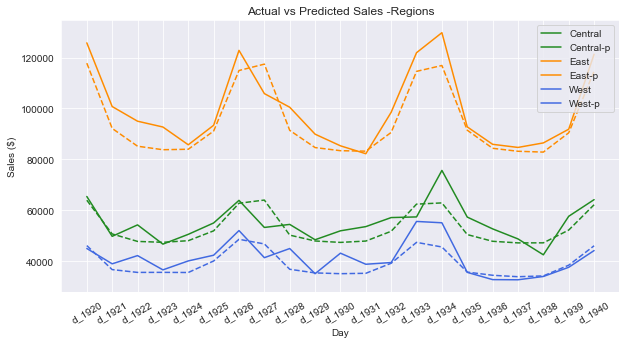

In [19]:
combined = combine (df_actual, df_predict, 'region', get_region)
plot_graph(combined,palette_region, "-Regions")

We notice that our forecasted sales (with the LGBM model) are smoother than actual sales. As stated above, it is extremely hard to predict peaks and troughs, as they depend on factors that are random in nature and unrecorded in our training set. Large errors like the one at d_19934 contribute to making mean absolute error so much higher than median absolute error.  

## By shop

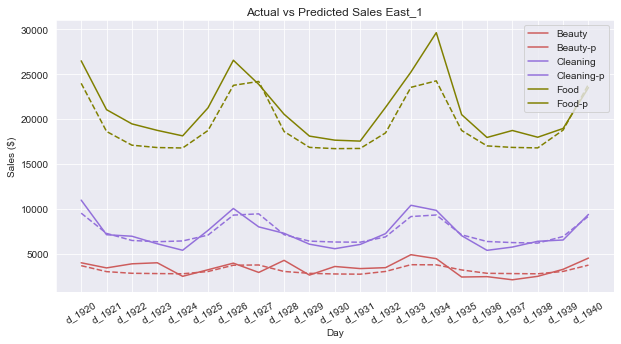

In [20]:
east1_actual = get_store_categories(df_actual, "East_1")
east1_predict = get_store_categories(df_predict, "East_1")
df = combine(east1_actual, east1_predict, 'category', get_category)
plot_graph(df, palette_cat, "East_1" )

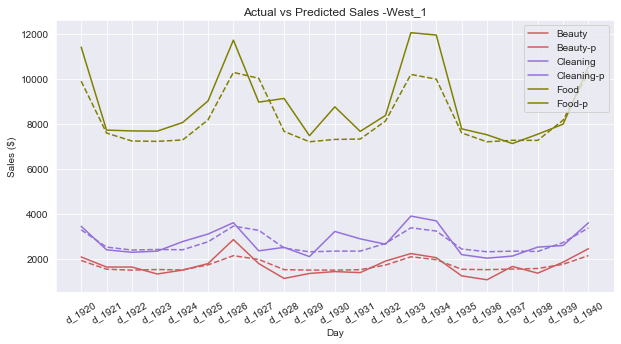

In [21]:
west1_actual = get_store_categories(df_actual,"West_1")
west1_predict = get_store_categories(df_predict,"West_1")
df = combine(west1_actual, west1_predict, 'category', get_category)
plot_graph(df, palette_cat,"-West_1")

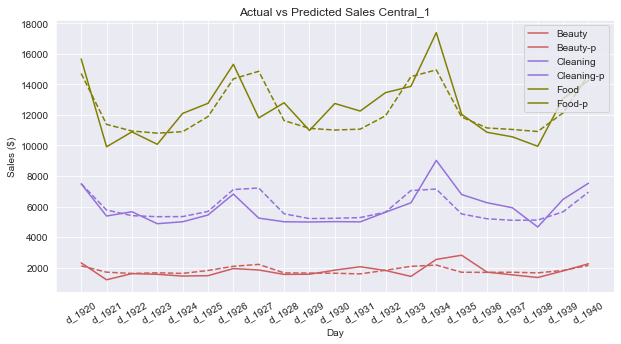

In [22]:
west1_actual = get_store_categories(df_actual,"Central_1")
west1_predict = get_store_categories(df_predict,"Central_1")
df = combine(west1_actual, west1_predict, 'category', get_category)
plot_graph(df, palette_cat,"Central_1")

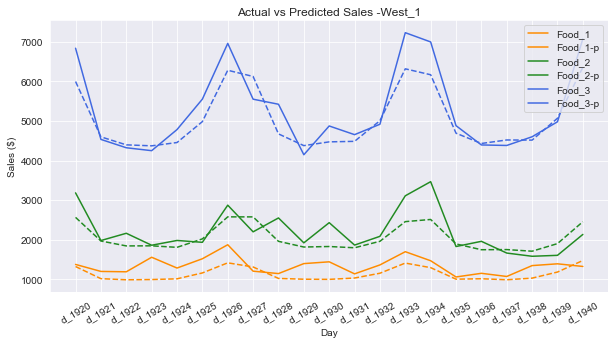

In [23]:
west1_actual = get_store_food(df_actual, "West_1")
west1_predict = get_store_food(df_predict, "West_1")
df = combine(west1_actual, west1_predict, 'subcategory', get_category)
plot_graph(df, palette_food, "-West_1")

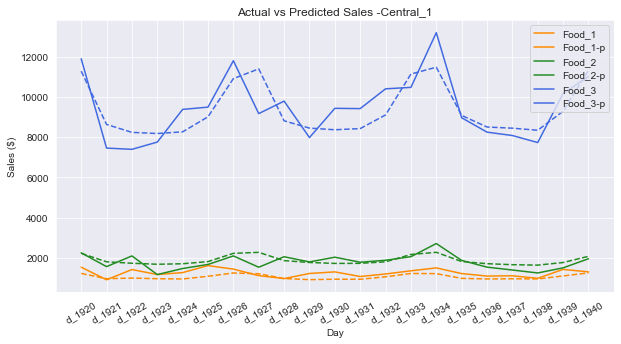

In [24]:
cen1_actual = get_store_food(df_actual, "Central_1")
cen1_predict = get_store_food(df_predict, "Central_1")
df = combine(cen1_actual, cen1_predict, 'subcategory', get_category)
plot_graph(df, palette_food, "-Central_1")

We notice that, even though absolute quantities differ, sales trends in the forcasted time period for different shops are similar, and our predictions tend to underpredict (d_1934) and overpredict (d_1927) the same days acorss shops. Furhter research should be done tu understand the beahviour of real sales those days. 

## By category

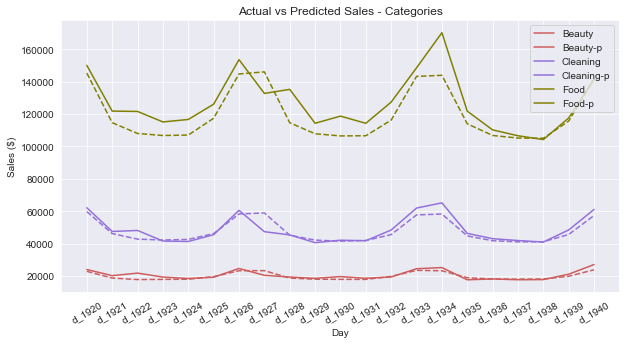

In [25]:
df = combine(df_actual, df_predict, 'category', get_category)
plot_graph(df, palette_cat, "- Categories")



Again, the same holds for predictions by category. 

In [29]:
def combine_two(predict,stats,groupby,get_func):
    predict_agg = get_func(predict)
    stats_agg = get_func(stats)
    predict_agg[groupby] = predict_agg[groupby].apply(lambda x: str(x+"-m"))
    stats_agg[groupby] = stats_agg[groupby].apply(lambda x: str(x+"-s"))
    combined = pd.concat([predict_agg, stats_agg], axis = 0)
    res = combined.groupby(by =[groupby]).sum()
    return res
res = combine_two(df_predict, df_stats, "region", get_region)


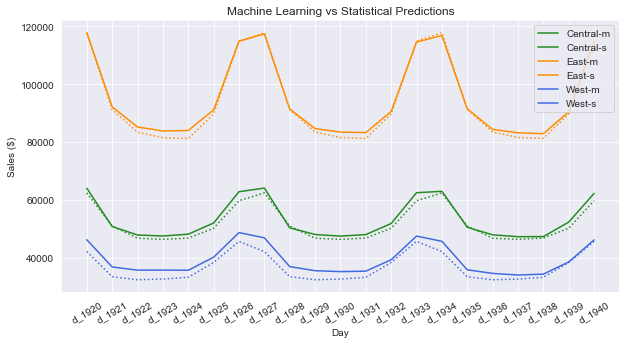

In [30]:
palette_compare = {"East-m": "darkorange", "Central-m":"forestgreen", "West-m":"royalblue"
,"East-s": "darkorange", "Central-s":"forestgreen", "West-s":"royalblue"}
g = sns.lineplot(data=res.T, dashes = False, palette = palette_compare,)
g.set_xticklabels(labels = res.T.index, rotation=30)
g.lines[0].set_linestyle("-")
g.lines[2].set_linestyle("-")
g.lines[4].set_linestyle("-")
g.lines[1].set_linestyle(":")
g.lines[3].set_linestyle(":")
g.lines[5].set_linestyle(":")
g.set_title("Machine Learning vs Statistical Predictions")
g.set(xlabel = "Day", ylabel = "Sales ($)")
plt.legend(loc='upper right')
plt.show()

Last, we notice that the predictions made by the ETS(AAA) model are extremely close to those made by the LGBM model. This suggests that little signal is left out for the models to pick up, and that probably, trying out different models and approaches would not result in huge gains in accuracy.